In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted

%pip install plotly==5.9.0
%pip install twisted
%pip install pandas
%pip install ta    
%pip install scikit-learn
%pip install tensorflow
%pip install keras
%pip install matplotlib
%pip install scikeras
%pip install keras-tuner
%pip install plotly
%pip install nbformat
%pip install lightgbm
%pip install seaborn
    
#%pip install huobi-sdk==2.3.3

import pandas as pd
import numpy as np    
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import os
# Downloading latest pytrade2 data
#os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
data_dir=f"../data/dev/common"
#print(f"Download completed. Local data dir: {data_dir}")

In [2]:
symbol="BTC-USDT"
history_days=10
#test_size=2/history_days # 2 days
test_size = 0.2
features_periods = ['5min', '15min', '1h']
predict_window = '5min'

# 0.01*0.012*2 - open+close comission 0.012%
# Comission is 4.8 for 40K price, ~10 for one open+close trade
comission_pct=0.012

comission=0.01*comission_pct*2 # doubled because open and close trade

open_ratio = 2
min_profit_ratio = (comission) * 5
max_loss_ratio = (comission) * 10

print(f'test size = {test_size}')

test size = 0.2


## Read candles history

In [3]:
from pathlib import Path

def read_candles(days = 1, period = '1min'):
    """ Read last days' 1 min candles from file system """

    candles_dir = Path(data_dir, 'candles')
    files = sorted([f for f in os.listdir(candles_dir) if f.endswith(f"candles_{period}.csv")])
    # Read last days' files to one dataframe
    df = pd.concat([pd.read_csv(Path(candles_dir, fname), parse_dates=['open_time', 'close_time']) for fname in files[-days:]])
    df = df.set_index('close_time', drop=False)
    #del(df['close_time.1']) # temp fix
    # Resample because row data contains multiple candles inside a period
    print(f'Read {len(df)} candles from {df.index.min()} to {df.index.max()}')
    return df.resample('1min').agg('last')

candles = read_candles(days=history_days)
candles.tail()

Read 14400 candles from 2024-01-18 00:01:00 to 2024-01-28 00:00:00


close_time           open_time    ticker interval     open     high      low    close    vol
close_time                                                                                                               
2024-01-27 23:56:00 2024-01-27 23:56:00 2024-01-27 23:55:00  BTC-USDT     1min  42107.8  42107.8  42107.7  42107.8   2214
2024-01-27 23:57:00 2024-01-27 23:57:00 2024-01-27 23:56:00  BTC-USDT     1min  42107.7  42115.1  42107.7  42115.1   6414
2024-01-27 23:58:00 2024-01-27 23:58:00 2024-01-27 23:57:00  BTC-USDT     1min  42117.2  42120.9  42117.1  42120.8   7770
2024-01-27 23:59:00 2024-01-27 23:59:00 2024-01-27 23:58:00  BTC-USDT     1min  42120.9  42120.9  42120.8  42120.8   3760
2024-01-28 00:00:00 2024-01-28 00:00:00 2024-01-27 23:59:00  BTC-USDT     1min  42120.9  42137.0  42120.8  42129.4  10772

## Calculate targets

In [4]:
import matplotlib.pyplot as plt

def plot_value_counts(ax, df, col, grouped, name):
    signals = df[col]
    #vc = signals[signals.diff() != 0].value_counts()
    vc = df[col].value_counts() if not grouped else signals[(signals.diff() != 0) & (signals != 0)].value_counts()
    label_map={0:'oom', 1:'buy', -1: 'sell'}
    color_map={'oom':'C0', 'buy': 'C1', 'sell': 'C2'}
    labels = [ label_map[signal] for signal in vc.index.tolist()]
    colors = [color_map[key] for key in labels]
    ax.pie(vc, labels = labels,  autopct= lambda x: '{:.0f}'.format(x*vc.sum()/100), colors = colors)
    tag = 'groups' if grouped else ''
    ax.set_title(f"{name} {col} {tag}")
    
def plot_signal_counts(df, name = ''):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    plot_value_counts(ax1, df, 'signal', grouped = False, name=name)
    plot_value_counts(ax2, df, 'signal', grouped = True, name=name)
    fig.suptitle(f'{name} signal counts from {df.index.min()} to {df.index.max()}')
    plt.show()

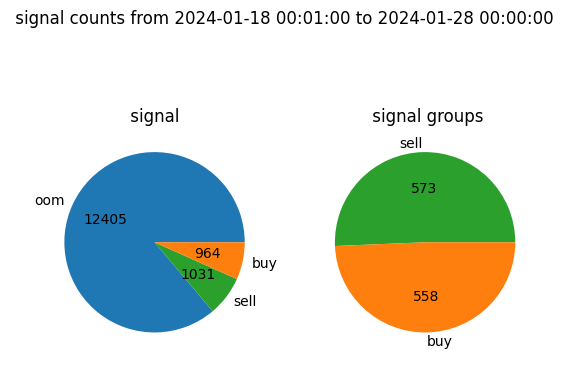

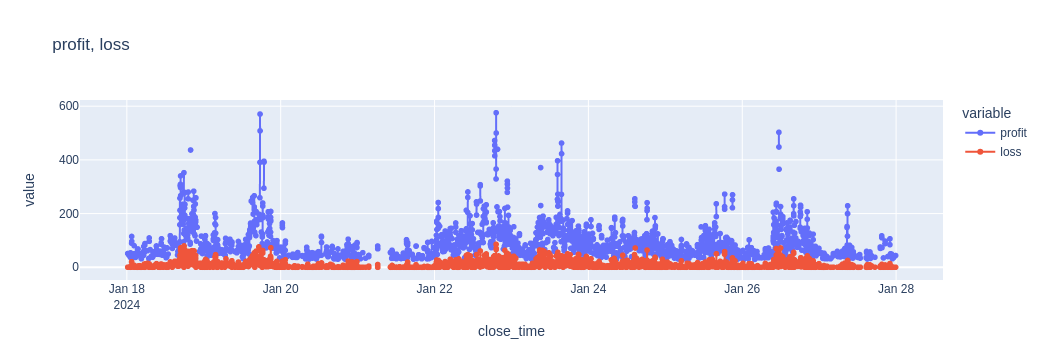

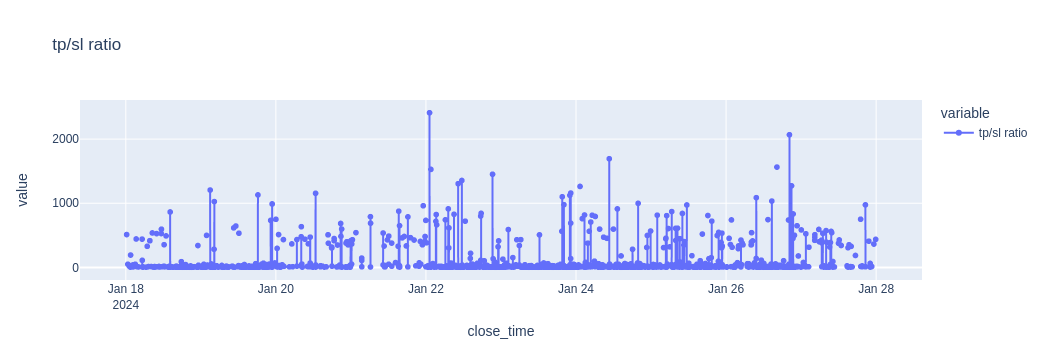

In [5]:

def calc_fut_lohi(candles, predict_window=predict_window):
    fut_lohi = pd.DataFrame(index=candles.index)
    fut_lohi[['fut_low', 'fut_high']] = (candles[['low', 'high']][::-1]
                                     .rolling(predict_window).agg({ 'low' : 'min', 'high' : 'max'})
                                     [::-1])
    # Drop last data with unfinished prediction windows
    fut_lohi = fut_lohi.iloc[fut_lohi.index <= max(fut_lohi.index)-pd.Timedelta(predict_window)]    
    return fut_lohi
    
def calc_signal(candles, fut_lohi, open_ratio=open_ratio, min_profit_ratio=min_profit_ratio, max_loss_ratio=max_loss_ratio, comission_pct=comission_pct):
    """ Signal -1,0,1 plus extended debugging info """
    #next_candles = candles[['open', 'high', 'low', 'close', 'vol']].shift(1)

    # next_candles = pd.DataFrame(index=candles.index)
    # next_candles[['high', 'low']] = (candles[['high', 'low']][::-1]
    #                                  .rolling(predict_window).agg({'high' : 'max', 'low' : 'min'})
    #                                  [::-1])

    # BTC-USDT 40 000 * 1% = 400
    # BTC-USDT 40 000 * 0.012% = 40 * 0.012 = 4,8
    #comission = comission_pct*0.01 
    comiss_abs = candles['close'] * comission_pct*0.01*2
    # Ratio to open: generate signal if profit/loss > open ratio
    #open_ratio = 1
    min_profit = candles['close']* min(comission_pct*0.01*2, min_profit_ratio)
    max_loss = candles['close']*max_loss_ratio
    
    signal = pd.DataFrame(index=candles.index)

    # todo: calc signal here
    # Profit / loss > open ratio considering comission and minimal profit
    profit_sell = (candles['low'] - fut_lohi['fut_low']) - comiss_abs
    loss_sell = (fut_lohi['fut_high'] - candles['low']) + comiss_abs
    signal_sell = (profit_sell > 0) & ((profit_sell / loss_sell) > open_ratio) & (profit_sell > min_profit) & (loss_sell < max_loss)

    
    # Profit / loss > open ratio considering comission and minimal profit
    profit_buy = (fut_lohi['fut_high'] - candles['high']) - comiss_abs
    loss_buy =  (candles['high'] - fut_lohi['fut_low']) + comiss_abs
    signal_buy = (profit_buy > 0) & ((profit_buy / loss_buy) > open_ratio)& (profit_buy > min_profit) & (loss_buy < max_loss)


    # Signal
    signal['signal'] = 0  # Default to 0
    signal.loc[signal_buy & ~signal_sell, 'signal'] = 1  # Set to 1 where 'buy' is True and 'sell' is False
    signal.loc[~signal_buy & signal_sell, 'signal'] = -1  # Set to -1 where 'sell' is True and 'buy' is False

    df = signal
    # Future profit and loss
    df.loc[signal['signal']==1, 'tp'] = fut_lohi['fut_high']
    df.loc[signal['signal']==1, 'sl'] = fut_lohi['fut_low']
    df.loc[signal['signal']==-1, 'tp'] = fut_lohi['fut_low']
    df.loc[signal['signal']==-1, 'sl'] = fut_lohi['fut_high']

    return df

def plot_sl_tp(candles, signal):
    # Line plot, profit/loss
    import plotly.express as px
    import warnings
    # Supress pandas+plotly warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    #px.line(signal, title='profit/loss').update_traces(mode='lines+markers').show()

    sltp = signal.copy()
    sltp['profit'] = (signal['tp'] - candles['close']).abs()
    sltp['loss'] = (signal['sl'] - candles['close']).abs()
    sltp['tp/sl ratio'] = sltp['profit']/sltp['loss']
    px.line(sltp[['profit','loss']], title='profit, loss').update_traces(mode='lines+markers').show()
    px.line(sltp['tp/sl ratio'], title='tp/sl ratio').update_traces(mode='lines+markers').show()
    
    #px.line(profits/losses, title='profit/loss ratio').update_traces(mode='lines+markers').show()
    
    pd.concat([candles, fut_lohi], axis=1).head()

candles.head()
fut_lohi = calc_fut_lohi(candles, predict_window)
signal = (calc_signal(candles, 
                      fut_lohi = fut_lohi, 
                      open_ratio = open_ratio, 
                      # 0.01*0.012*2 - open+close comission 0.012%
                      # Comission is 4.8 for 40K price, ~10 for one open+close trade
                      min_profit_ratio = min_profit_ratio,
                      max_loss_ratio = max_loss_ratio)
         )



# Pie plot, signals
plot_signal_counts(signal)
plot_sl_tp(candles, signal)


## Feature engineering


### Calculate indicators

In [6]:
from ta import trend, momentum, volume, others, volatility


def time_parts_of(candles: pd.DataFrame):
    # dt = df.index.to_frame()["close_time"].dt
    df = pd.DataFrame(index=candles.index)
    dt = df.index.astype('datetime64[ns]')
    df["time_hour"] = dt.hour
    df["time_minute"] = dt.minute
    return df

def ichimoku_of(candles: pd.DataFrame, period: str=''):
    df = pd.DataFrame()
    ichimoku = trend.IchimokuIndicator(candles['high'], candles['low'])
    df[f'ichimoku_base_line_{period}'] = ichimoku.ichimoku_base_line()
    df[f'ichimoku_conversion_line_{period}'] = ichimoku.ichimoku_conversion_line()
    df[f'ichimoku_a_{period}'] = ichimoku.ichimoku_a()
    df[f'ichimoku_b_{period}'] = ichimoku.ichimoku_b()    
    return df
    
def prev_candles_of(candles: pd.DataFrame, window_size):
    df = candles[["open", "high", "low", "close", "vol"]]
    cols = ["open", "high", "low", "close", "vol"]
    features = candles[cols].copy()
    # Add previous window candles to columns
    concat_features = [features]
    for i in range(1, window_size):
        prefix = f"-{i}_"
        prev_cols_map = {col: prefix + col for col in cols}
        prev_features = features[cols].shift(i).rename(prev_cols_map, axis=1)
        concat_features.append(prev_features)
    features = pd.concat(concat_features, axis=1).sort_index()

    # Add prefix to ohlcv columns
    # for col in cols:
    #     features.rename(columns={col: f"_{col}"}, inplace=True)

    return features.dropna()    

def indicators_of(candles, period):
    resampled = candles.resample(period).agg({'high':max, 'low':min, 'open': 'first', 'close': 'last', 'vol': sum})
    df = ichimoku_of(resampled, period)
    df[f'cci_{period}'] = trend.cci(resampled['high'], resampled['low'], resampled['close'])
    df[f'adx_{period}'] = trend.adx(resampled['high'], resampled['low'], resampled['close'])
    df[f'rsi_{period}'] = momentum.rsi(resampled['close'])
    df[f'stoch_{period}'] = momentum.stoch(resampled['high'], resampled['low'], resampled['close'])
    df[f'macd_{period}'] = trend.macd(resampled['close'])
    #df = features.dropna()
    return df
    
# Create time features and indicators
features = time_parts_of(candles)
#features = pd.concat([features] + [indicators_of(candles,period) for period in ['1min', '5min', '15min', '30min', '60min']], axis=1).ffill()
features = pd.concat([features] + [indicators_of(candles,period) for period in features_periods], axis=1).ffill()



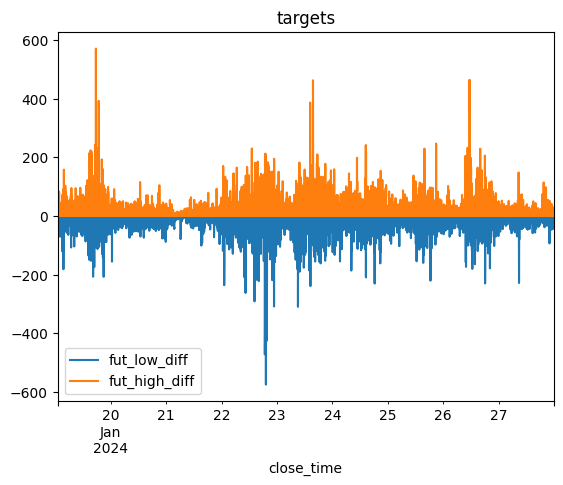

In [7]:
def prepare_xy(candles, features, targets):
    t = pd.DataFrame()
    t['fut_low_diff'] = targets['fut_low'] - candles['low']
    t['fut_high_diff'] = targets['fut_high'] - candles['high']
    t = t.dropna()
    
    f = features.copy()
    float_cols=[c for c in f.columns if not c.startswith('time') and not c.endswith('time')]
    f[float_cols]=f[float_cols].diff()
    f = f.dropna()

    ii = t.index.intersection(f.index)
    f,t = f.loc[ii,:], t.loc[ii,:]
    return f,t

x, y = prepare_xy(candles, features, fut_lohi)
y.plot(title='targets')
plt.show()

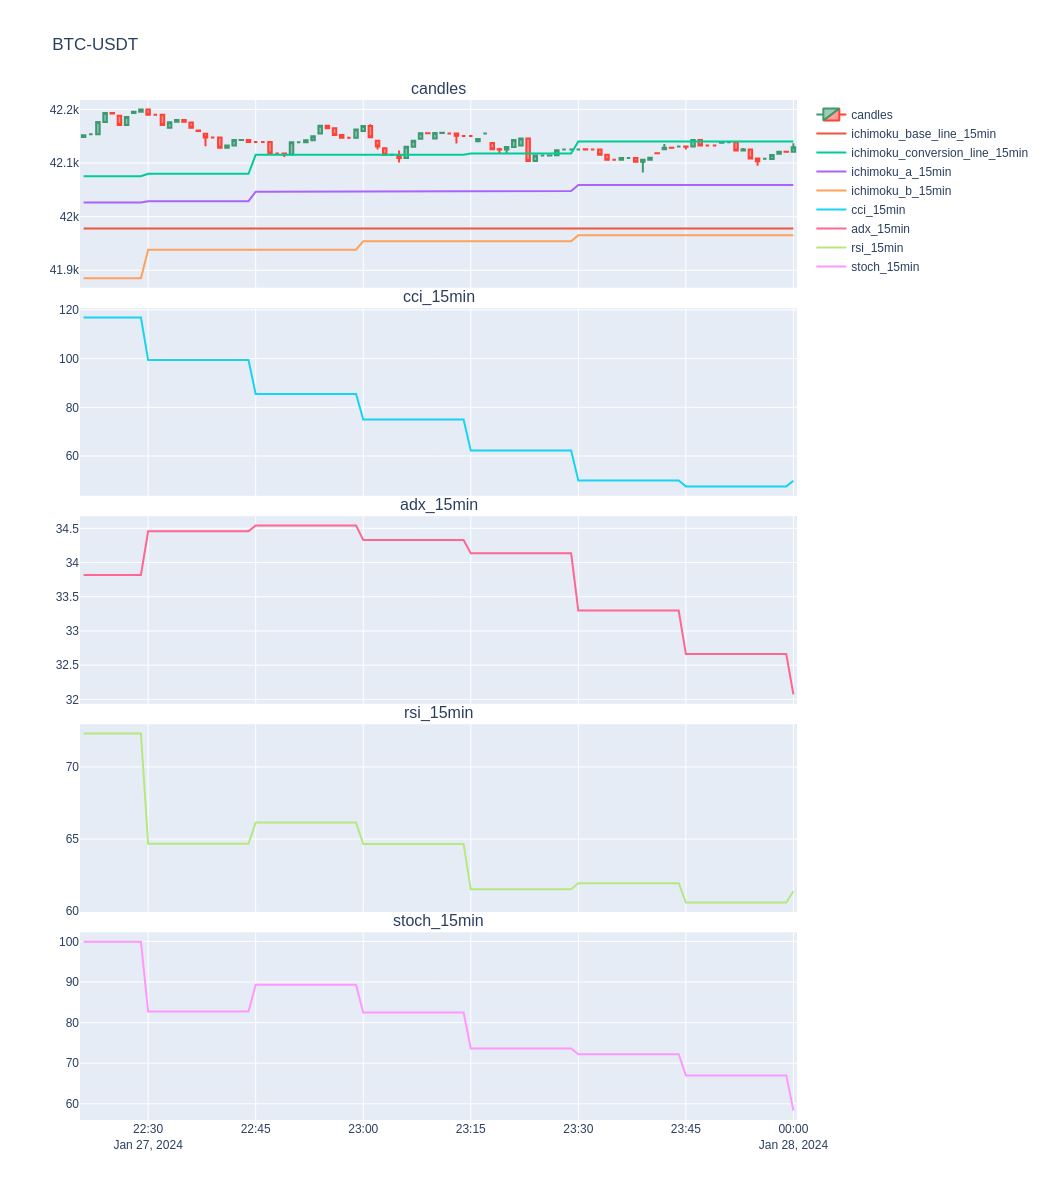

In [8]:
import plotly as py
from plotly import graph_objects as go
from plotly.subplots import make_subplots

def plot_indicators(candles, df, extra_lines:[], extra_subplots:[]):
    fig = make_subplots(rows=len(extra_subplots)+1, cols=1, 
                        shared_xaxes=True,
                        vertical_spacing=0.02,
                        subplot_titles=['candles']+extra_subplots
                       )    
    
    # Candles
    fig.add_trace(go.Candlestick(\
                        name='candles',
                        x=candles.index,\
                        open=candles['open'],\
                        high=candles['high'],\
                        low=candles['low'],\
                        close=candles['close'])
                     , row=1, col=1)

    # Other charts on candles chart
    for name in extra_lines:
        fig.add_trace(go.Scatter(name=name, x=df.index, y=df[name], mode='lines'), row=1, col=1)

    # Other subplots below candles
    for i, col in enumerate(extra_subplots):
        fig.add_trace(go.Scatter(name=col, x=df.index,y=df[col], mode='lines'), row=2+i, col=1)
    
    fig.update_layout(title=f"{candles['ticker'][0]}",
                    xaxis_rangeslider_visible=False, 
                    height=300*len(extra_subplots))
    fig.show()

suffix = f'_{min(features_periods)}'
ichimoku_cols = [f'ichimoku_base_line{suffix}', f'ichimoku_conversion_line{suffix}', f'ichimoku_a{suffix}', f'ichimoku_b{suffix}']
indicators_cols = [f'cci{suffix}', f'adx{suffix}', f'rsi{suffix}', f'stoch{suffix}']
plot_indicators(
            candles.tail(100),
            features.tail(100), 
             extra_lines=ichimoku_cols,
             extra_subplots=indicators_cols)


### Create features

<Axes: >

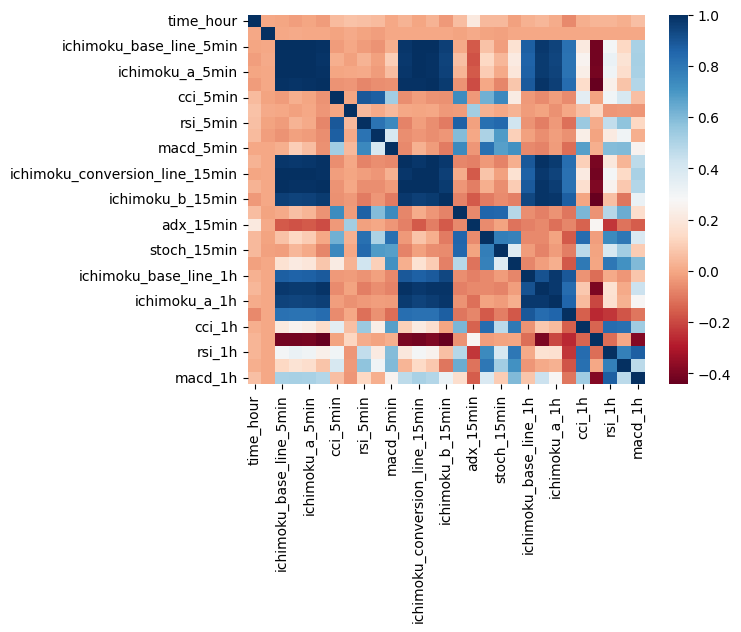

In [9]:
import seaborn as sb
corr = features.corr()
kot = corr[corr.abs()>=.5]
#corr = corr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
# Plot the heatmap between features in the dataframe
sb.heatmap(corr, annot=False,
           cbar=True, cmap='RdBu', fmt='.1f')

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler, MaxAbsScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


def create_pipe(X, y) -> (Pipeline, Pipeline):
    """ Create feature and target pipelines to use for transform and inverse transform """

    time_cols = [col for col in X.columns if col.startswith("time") or col.endswith("time")]
    float_cols = list(set(X.columns) - set(time_cols))

    # # Scale x
    # x_pipe = Pipeline(
    #     [
    #     ("xrs", ColumnTransformer([("xrs", StandardScaler(), float_cols)], remainder="passthrough")),
    #     ("mas", MaxAbsScaler()),
    #     ])

    # x_pipe.fit(X)

    # # Scale y
    # y_pipe = Pipeline(
    #     [
    #    ("xrs", StandardScaler()),
    #     ("ymms", MaxAbsScaler()),
    #     ])
    # y_pipe.fit(y)

    
    # Scale x
    x_pipe = Pipeline(
        [
        ("xscaler", ColumnTransformer([("xrs", StandardScaler(), float_cols)], remainder="passthrough")),
        ("mas", MaxAbsScaler()),
        ])
    x_pipe.fit(X)

    # Scale y
    y_pipe = Pipeline(
        [
        ("xrs", StandardScaler()),
        ("ymms", MaxAbsScaler()),
        ])
    y_pipe.fit(y)
    return x_pipe, y_pipe


x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x, y, test_size=test_size, shuffle=False)
x_pipe, y_pipe = create_pipe(x_train_df, y_train_df)
float_cols = [col for col in x_train_df.columns if not col.startswith('time')]

x_train_df[float_cols] = x_train_df[float_cols].diff()
x_train_df = x_train_df.dropna()
y_train_df = y_train_df[y_train_df.index.isin(x_train_df.index)]
x_test_df[float_cols] = x_test_df[float_cols].diff()
x_test_df = x_test_df.dropna()
y_test_df = y_test_df[y_test_df.index.isin(x_test_df.index)]

x_train = x_pipe.transform(x_train_df)
x_test = x_pipe.transform(x_test_df)
y_train = y_pipe.transform(y_train_df)
y_test = y_pipe.transform(y_test_df)

2024-02-02 22:14:12.770092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 22:14:12.770123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 22:14:12.771437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 22:14:12.779330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 22:14:13.642440: W tensorflow/comp

## Try keras model

In [11]:
models={}

In [12]:
from keras import Sequential, Input
from keras.layers import Dense, Dropout
import plotly.express as px
import collections


plot_figsize=(10,5)

def create_models(*specs):
    models = {}
    for unit_spec in specs:
        window_size=unit_spec[0]
        models[f'keras '+str(unit_spec)] =create_model(x_train, y_train, unit_spec)
    return models

def create_model(x_train,  y_train, specs):
    """ Create model with layers given in specs """

    input_shape=(x_train.shape[1],)
    print(f"Creating model({specs}), input shape={input_shape}")

    model = Sequential()
    model.add(Input(shape=input_shape))

    # Keras layers
    for units in specs:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(y_train.shape[1], activation='linear')) # Softmax for classification
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    #print(model.summary())
    return model

def plot_history_plotly(df, title):
    px.line(df,title=title).update_traces(mode='lines+markers').show()
    
def plot_history_plt(df, title):
        plt.plot(df)
        #Captions and show the plot
        plt.title(title)
        plt.xlabel('epoch')
        plt.legend(df.columns)
        plt.show()    

def plot_history(model_name, history, plot_func, metric=None):
    """ Plot history loss and metrics"""
    metric_names = [metric] if metric else history.history
    # Print all merrics
    for metric_name in metric_names:
        # Validation metrics names will be calculated from related train metrics
        if metric_name.startswith("val_"): continue

        # Plot metric and related test (val_..) metric
        plt.figure(figsize=plot_figsize)
        title=f"{model_name} {metric_name}"
        names=[metric_name, f"val_{metric_name}"]
        
        df=pd.DataFrame()
        for name in names:
            df[name] = history.history[name]
        plot_func(df, title)

def evaluate_keras_models(models, epochs=10):
    results={}
    for name, model in models.items():
        print('Evaluating ' + name)
        steps_per_epoch=max(1,x_train.shape[0]//epochs)+1
        history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)
        results[name] = history
    return results

def plot_res(results, plot_func):
    for model_name in results:
        plot_history(model_name, results[model_name], plot_func, metric='mean_squared_error')

        
# # Good: Current LSTM2: 10, 320, 0.2, 160, 0.2, 40, 0.2, 16, 0.1
# input_size = x_train.shape[1]

# keras_models = create_models([input_size],
#                             [input_size, input_size*4, 16],
#                             [input_size, input_size, input_size*4, 64,16])
# models.update(keras_models)
# eval_res = evaluate_keras_models(keras_models, 10)

# plot_res(eval_res, plot_history_plt)

## Try lightdbm

In [13]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
def eval_lgb_model(lgb_model, train_data, test_data):
    # Defining parameters for the LightGBM
    params = {
        'objective': 'regression',
        'metric': ['mse', 'mae', 'rmse', 'r2'],
        'verbose': -1
    }
    rounds = 100
    evals = {}
    #model.fit(x_train, y_train, callbacks=[lgb.record_evaluation(evals)])
    model.fit(train_data, test_data, callbacks=[lgb.record_evaluation(evals)])
    return model, evals

lgb_model=lgb.LGBMRegressor()
model = MultiOutputRegressor(lgb_model)
#models['lgbm1'] = model
lgb_models = {'lgb1': model}
models.update(lgb_models)

model, evals = eval_lgb_model(lgb_model, x_train, y_train)
for metrics in evals.values():
    for metric in metrics:
        lgb.plot_metric(evals, metric)

plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5020
[LightGBM] [Info] Number of data points in the train set: 10315, number of used features: 29
[LightGBM] [Info] Start training from score 0.000009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5020
[LightGBM] [Info] Number of data points in the train set: 10315, number of used features: 29
[LightGBM] [Info] Start training from score -0.000001


## Calculate test profit

Calculating profit of model lgb1
Average profit: -6.019676355528645
Average buy: -5.0624483044375665
Average sell: -40.27622544882979


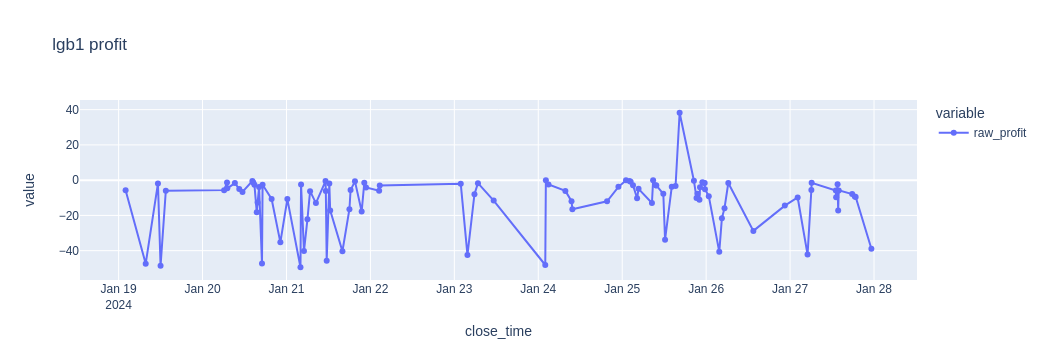

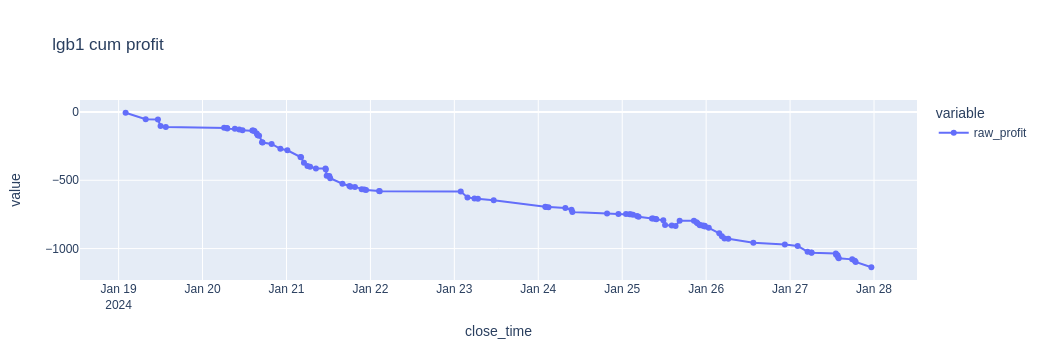

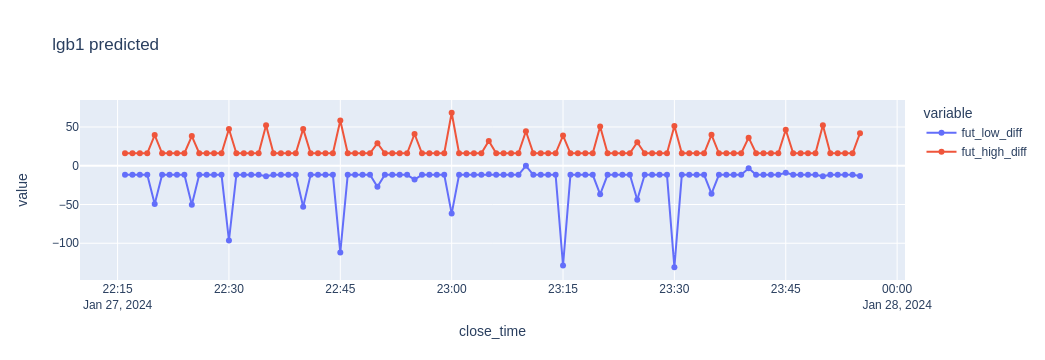

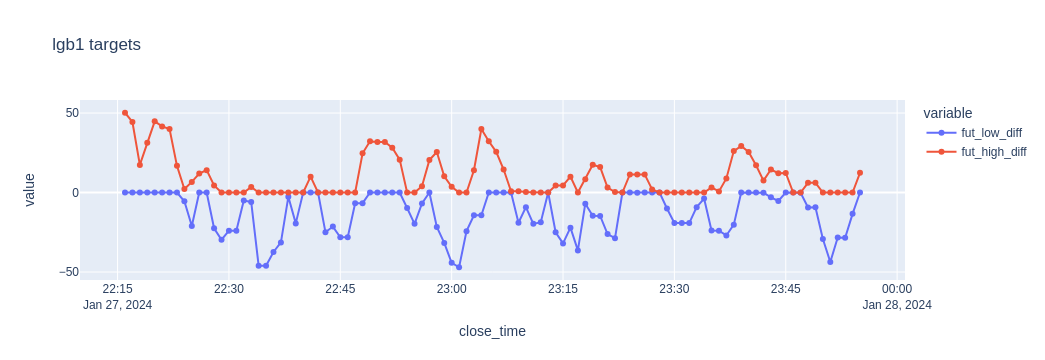

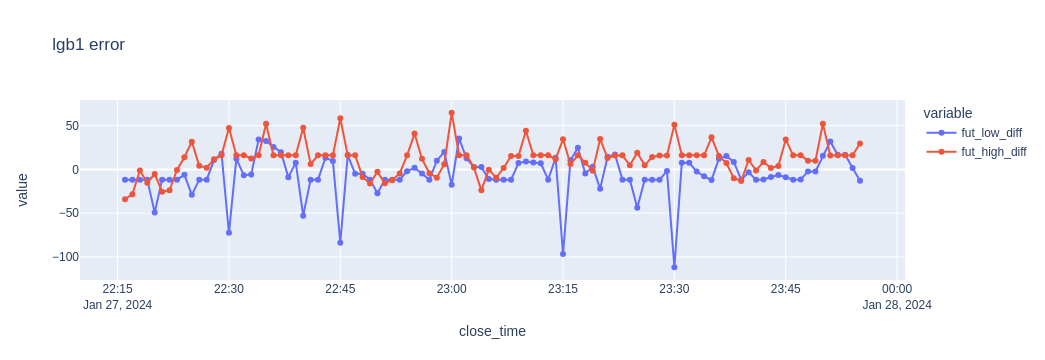

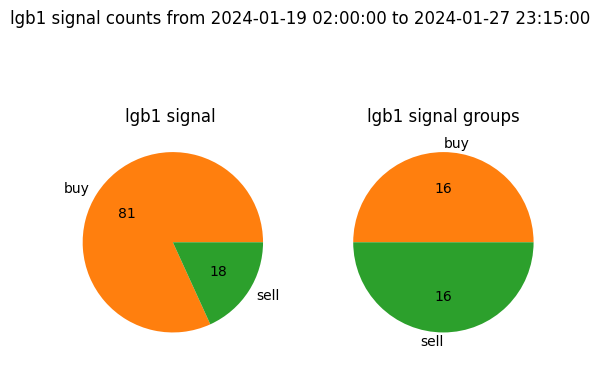

In [14]:
import matplotlib.pyplot as plt
import plotly.express as px
def calc_profit(y_pred, fut_lohi, candles):

    ii = y_pred.index.intersection(fut_lohi.index)
    y_pred = y_pred[y_pred.index.isin(ii)]

    y_pred['fut_low'] = candles['low'] + y_pred['fut_low_diff']
    y_pred['fut_high'] = candles['high'] + y_pred['fut_high_diff']
    
    fut_lohi = fut_lohi[fut_lohi.index.isin(ii)]

    # Calc signal from predicted low/high
    y_signal = calc_signal(candles, y_pred)
    y_signal = y_signal[y_signal['signal']!=0].dropna()

    # Set profit/loss for 1 and -1, because 0 is excluded before
    profit = (y_signal['tp']-candles['close']).abs()
    loss = (y_signal['sl']-candles['close']).abs()
    
    is_buy_profit = ((y_signal['signal']==1) 
                     & (y_pred['fut_low'] <= fut_lohi['fut_low']) 
                     & (y_pred['fut_high'] <= fut_lohi['fut_high']))
    is_buy_loss = (y_signal['signal']==1) & (~is_buy_profit)

    is_sell_profit = ((y_signal['signal']==-1) 
                     & (y_pred['fut_high'] >= fut_lohi['fut_high']) 
                     & (y_pred['fut_low'] >= fut_lohi['fut_low']))
    is_sell_loss = (y_signal['signal']==-1) & (~is_sell_profit)

    # Calc profit
    profit_df = y_signal[['signal']].copy()
    profit_df.loc[is_buy_profit | is_sell_profit,['raw_profit']] = profit
    profit_df.loc[is_buy_loss | is_sell_loss, 'raw_profit'] = -loss
    
    return y_pred[['fut_low_diff', 'fut_high_diff']], profit_df

def plot_profits(name, profit_df, y_pred, n_show=100):

        # Profit plot
        print('Average profit: ' + str(profit_df['raw_profit'].median()))
        print('Average buy: ' + str(profit_df[profit_df['signal']==1]['raw_profit'].median()))
        print('Average sell: ' + str(profit_df[profit_df['signal']==-1]['raw_profit'].median()))

        px.line(profit_df['raw_profit'], title=f'{name} profit').update_traces(mode='lines+markers').show()
        px.line(profit_df['raw_profit'].cumsum(), title=f'{name} cum profit').update_traces(mode='lines+markers').show()

        # Predicted and target value
        px.line(y_pred.tail(n_show), title=f'{name} predicted').update_traces(mode='lines+markers').show()
        px.line(y.tail(n_show), title=f'{name} targets').update_traces(mode='lines+markers').show()
        px.line((y_pred-y_test_df).tail(n_show),title=f'{name} error').update_traces(mode='lines+markers').show()

        # Signals counts piecharts
        plot_signal_counts(profit_df, name)    
        plt.show() 

def eval_models_profits(models):
    for name, model in models.items():
        print(f'Calculating profit of model {name}')
        # Predict
        y_pred_raw = model.predict(x)
        y_pred = y_pipe.inverse_transform(y_pred_raw)
        y_pred = pd.DataFrame(data=y_pred, columns=['fut_low_diff', 'fut_high_diff'], index = x.index)        

        # Calculate profit
        y_pred, profit_df = calc_profit(y_pred, fut_lohi, candles)
        plot_profits(name, profit_df, y_pred)

# Check case with 100% correct prediction
# y_pred_simulate = fut_lohi.copy()
# y_pred_simulate['fut_low_diff'] = y_pred_simulate['fut_low'] - candles.loc[y_pred_simulate.index, 'low']
# y_pred_simulate['fut_high_diff'] = y_pred_simulate['fut_high'] - candles.loc[y_pred_simulate.index, 'high']
# y_pred, profit_df = calc_profit( y_pred_simulate, fut_lohi, candles)
# plot_profits('fut_lohi', profit_df, y_pred)

eval_models_profits(lgb_models)
##eval_models_profits(keras_models)